In [11]:
import os
import pandas as pd

data_dir = '..\\data\\raw'
# afrr activation data
affr_act = os.path.join(data_dir, 'GUI_BALANCING_OFFERS_AND_RESERVES_202312312300-202412312300.csv')
affr_act_df = pd.read_csv(affr_act, delimiter=',')
affr_act_24 = os.path.join(data_dir, 'GUI_BALANCING_OFFERS_AND_RESERVES_202412312300-202512312300.csv')
affr_act_24_df = pd.read_csv(affr_act_24, delimiter=',')
affr_act_df = pd.concat([affr_act_24_df, affr_act_df], ignore_index=True)

affr_act_df.rename(columns={'ISP (CET/CEST)': 'Time'}, inplace=True)
affr_act_df['Time'] = pd.to_datetime(affr_act_df['Time'].str[:16], format='%d/%m/%Y %H:%M')
affr_act_df.set_index('Time', inplace=True)
affr_act_df = affr_act_df.where(affr_act_df['Reserve Type'] == 'aFRR').dropna(subset=['Reserve Type'])

# Correct column names use (MWh), not (MW)
affr_act_df.rename(columns={
    'Regulation Up - Activated [17.1.E] (MWh)': 'aFRR Activated Up',
    'Regulation Down - Activated [17.1.E] (MWh)': 'aFRR Activated Down'
}, inplace=True)

# Select only the renamed activation columns
affr_act_df = affr_act_df[['aFRR Activated Up', 'aFRR Activated Down']]

affr_act_df.head(10)

,aFRR Activated Up,aFRR Activated Down
Time,,
2025-01-01 00:00:00,0.51,13.65
2025-01-01 01:00:00,0.00,19.04
2025-01-01 02:00:00,10.98,0.69
2025-01-01 03:00:00,1.50,9.37
2025-01-01 04:00:00,11.67,2.30
2025-01-01 05:00:00,15.38,0.89
2025-01-01 06:00:00,0.06,36.32
2025-01-01 07:00:00,0.00,28.09
2025-01-01 08:00:00,0.00,14.61


# aFRR Activated Up/Down — quick exploration
This section summarizes the distribution and seasonality of aFRR activation volumes loaded above. It assumes `affr_act_df` contains 15-min rows indexed by time and two numeric columns: `aFRR Activated Up` and `aFRR Activated Down` (MWh).

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Make a copy and ensure numeric types
df = affr_act_df.copy()
for col in ['aFRR Activated Up', 'aFRR Activated Down']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.sort_index()
df[['aFRR Activated Up','aFRR Activated Down']] = df[['aFRR Activated Up','aFRR Activated Down']].fillna(0.0)

# Basic summary
total_rows = len(df)
up = df['aFRR Activated Up']
down = df['aFRR Activated Down']
up_pos = (up > 0).sum()
down_pos = (down > 0).sum()
summary = {
    'rows': total_rows,
    'up_nonzero': int(up_pos),
    'down_nonzero': int(down_pos),
    'up_rate': float(up_pos / total_rows),
    'down_rate': float(down_pos / total_rows),
    'up_mean': float(up.mean()),
    'down_mean': float(down.mean()),
    'up_median': float(up.median()),
    'down_median': float(down.median()),
    'up_p95': float(np.quantile(up, 0.95)),
    'down_p95': float(np.quantile(down, 0.95)),
    'up_p99': float(np.quantile(up, 0.99)),
    'down_p99': float(np.quantile(down, 0.99)),
}
summary

{'rows': 17544,
 'up_nonzero': 6933,
 'down_nonzero': 9936,
 'up_rate': 0.3951778385772914,
 'down_rate': 0.5663474692202463,
 'up_mean': 2.8945992932056543,
 'down_mean': 7.498469562243503,
 'up_median': 0.0,
 'down_median': 0.84,
 'up_p95': 15.34,
 'down_p95': 32.718499999999985,
 'up_p99': 28.45989999999998,
 'down_p99': 52.58419999999998}

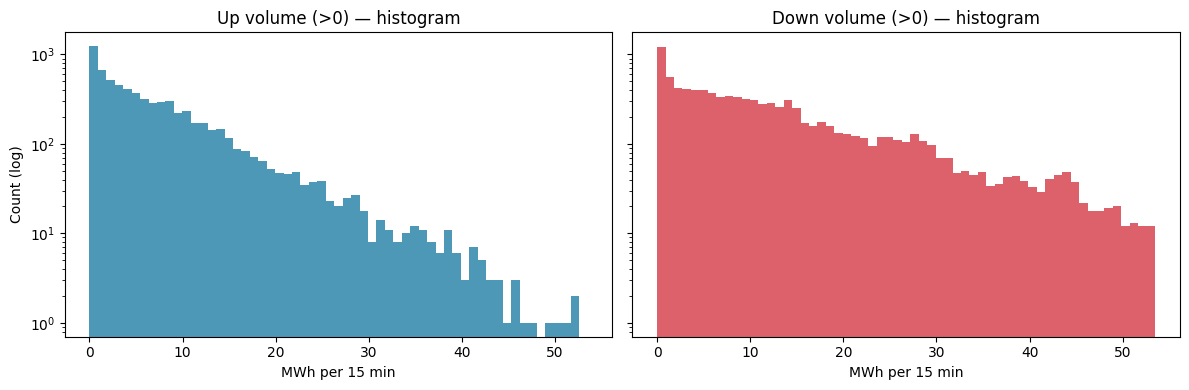

Zero-share — Up: 60.5%, Down: 43.4%


In [13]:
# Histograms of positive volumes (clip to 99th percentile to visualize the body of the distribution)
up_pos = up[up > 0]
down_pos = down[down > 0]
if len(up_pos) == 0 and len(down_pos) == 0:
    print('No positive activations found.')
else:
    both = np.concatenate([up_pos.values if len(up_pos) else np.array([0]),
                           down_pos.values if len(down_pos) else np.array([0])])
    high = np.quantile(both, 0.99) if both.size else 0.0
    bins = np.linspace(0, max(high, 1e-6), 60) if high > 0 else 30
    fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
    axes[0].hist(up_pos, bins=bins, color='#2E86AB', alpha=0.85)
    axes[0].set_title('Up volume (>0) — histogram')
    axes[0].set_xlabel('MWh per 15 min')
    axes[0].set_ylabel('Count (log)')
    axes[0].set_yscale('log')

    axes[1].hist(down_pos, bins=bins, color='#D64550', alpha=0.85)
    axes[1].set_title('Down volume (>0) — histogram')
    axes[1].set_xlabel('MWh per 15 min')
    axes[1].set_yscale('log')
    plt.tight_layout()
    plt.show()

    # Share zero-share for context
    print(f"Zero-share — Up: {(1 - len(up_pos)/len(up))*100:.1f}%, Down: {(1 - len(down_pos)/len(down))*100:.1f}%")

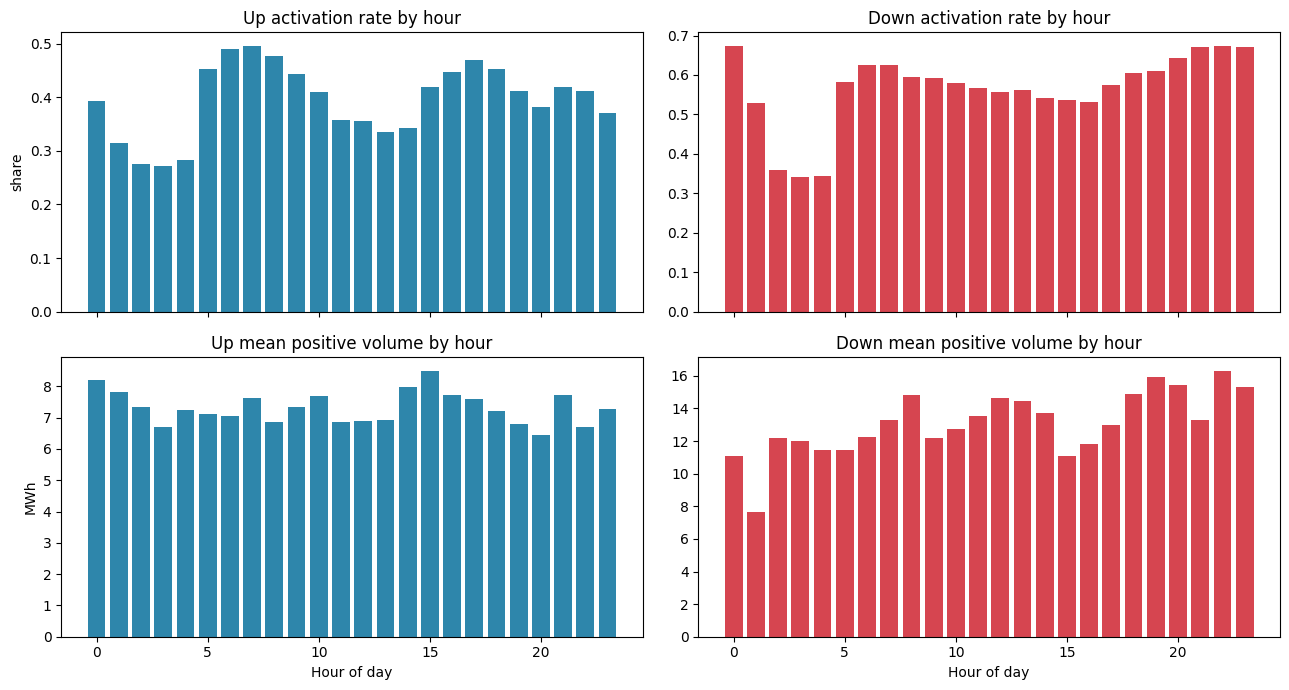

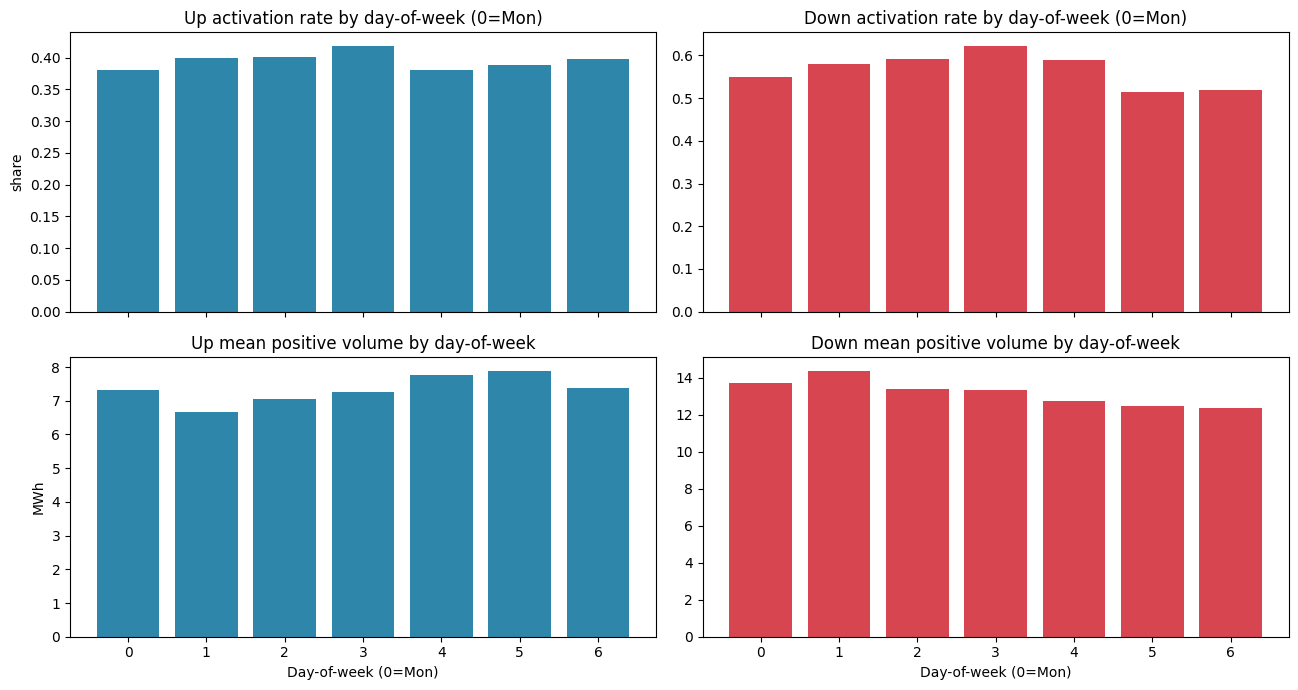

(       up_rate  up_pos_mean  down_rate  down_pos_mean
 hour                                                 
 0     0.392613     8.191394   0.673051      11.100285
 1     0.314637     7.811174   0.528044       7.678394
 2     0.274966     7.337015   0.359781      12.171635
 3     0.272230     6.697940   0.340629      11.978072
 4     0.283174     7.255362   0.343365      11.448606
 5     0.452804     7.116073   0.582763      11.472840
 6     0.491108     7.050752   0.625171      12.231947
 7     0.496580     7.631763   0.625171      13.286915
 8     0.477428     6.848424   0.595075      14.828368
 9     0.443228     7.337346   0.592339      12.207159
 10    0.410397     7.697200   0.580027      12.722052
 11    0.357045     6.849349   0.567715      13.515084
 12    0.355677     6.899308   0.556772      14.672408
 13    0.335157     6.918571   0.562244      14.449513
 14    0.343365     7.978884   0.541724      13.740960
 15    0.418605     8.500131   0.536252      11.066582
 16    0.4

In [14]:
# Hour-of-day and day-of-week activation rate and mean positive volume
tmp = df.copy()
tmp['hour'] = tmp.index.hour
tmp['dow'] = tmp.index.dayofweek  # 0=Mon

def rate(s):
    return float((s > 0).mean())

def pos_mean(s):
    s = s[s > 0]
    return float(s.mean()) if len(s) else 0.0

hour = tmp.groupby('hour').agg({
    'aFRR Activated Up': [rate, pos_mean],
    'aFRR Activated Down': [rate, pos_mean],
})
hour.columns = ['up_rate','up_pos_mean','down_rate','down_pos_mean']

dow = tmp.groupby('dow').agg({
    'aFRR Activated Up': [rate, pos_mean],
    'aFRR Activated Down': [rate, pos_mean],
})
dow.columns = ['up_rate','up_pos_mean','down_rate','down_pos_mean']

fig, axes = plt.subplots(2, 2, figsize=(13,7), sharex='col')
axes[0,0].bar(hour.index, hour['up_rate'], color='#2E86AB')
axes[0,0].set_title('Up activation rate by hour')
axes[0,0].set_ylabel('share')
axes[1,0].bar(hour.index, hour['up_pos_mean'], color='#2E86AB')
axes[1,0].set_title('Up mean positive volume by hour')
axes[1,0].set_xlabel('Hour of day')
axes[1,0].set_ylabel('MWh')

axes[0,1].bar(hour.index, hour['down_rate'], color='#D64550')
axes[0,1].set_title('Down activation rate by hour')
axes[1,1].bar(hour.index, hour['down_pos_mean'], color='#D64550')
axes[1,1].set_title('Down mean positive volume by hour')
axes[1,1].set_xlabel('Hour of day')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(13,7), sharex='col')
axes[0,0].bar(dow.index, dow['up_rate'], color='#2E86AB')
axes[0,0].set_title('Up activation rate by day-of-week (0=Mon)')
axes[0,0].set_ylabel('share')
axes[1,0].bar(dow.index, dow['up_pos_mean'], color='#2E86AB')
axes[1,0].set_title('Up mean positive volume by day-of-week')
axes[1,0].set_xlabel('Day-of-week (0=Mon)')
axes[1,0].set_ylabel('MWh')

axes[0,1].bar(dow.index, dow['down_rate'], color='#D64550')
axes[0,1].set_title('Down activation rate by day-of-week (0=Mon)')
axes[1,1].bar(dow.index, dow['down_pos_mean'], color='#D64550')
axes[1,1].set_title('Down mean positive volume by day-of-week')
axes[1,1].set_xlabel('Day-of-week (0=Mon)')
plt.tight_layout()
plt.show()

hour, dow

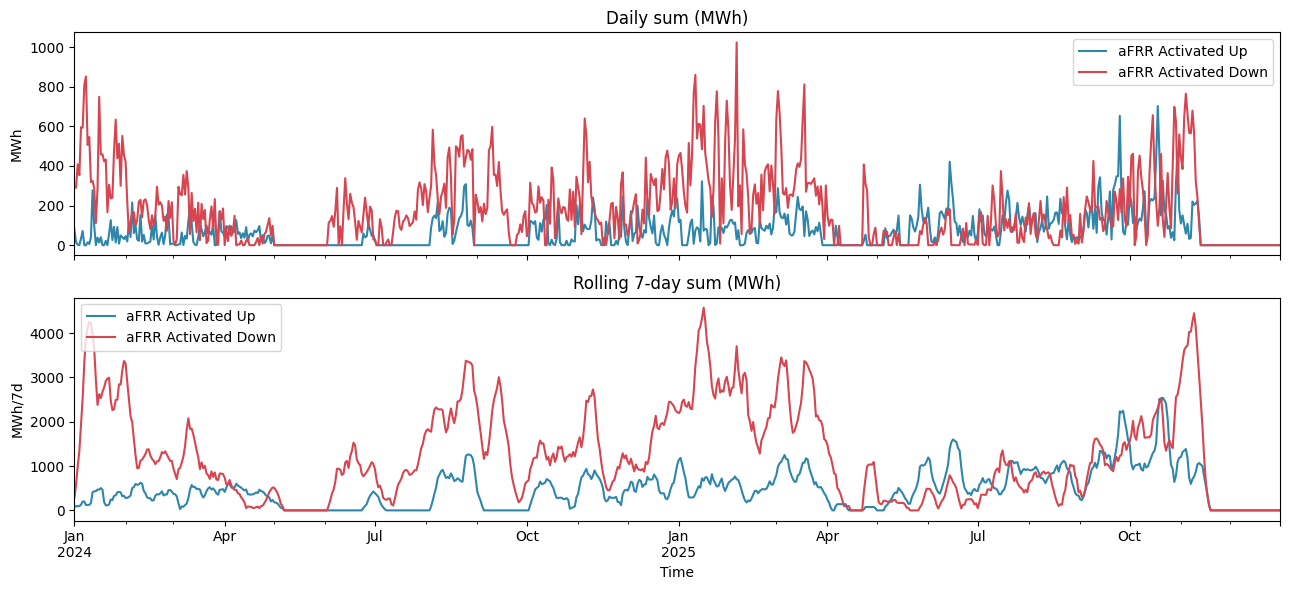

,aFRR Activated Up,aFRR Activated Down
Time,,
2025-12-27,0.0,0.0
2025-12-28,0.0,0.0
2025-12-29,0.0,0.0
2025-12-30,0.0,0.0
2025-12-31,0.0,0.0


In [15]:
# Daily sums and 7-day rolling sum
daily = df[['aFRR Activated Up','aFRR Activated Down']].resample('D').sum()
roll7 = daily.rolling(7, min_periods=1).sum()

fig, ax = plt.subplots(2, 1, figsize=(13,6), sharex=True)
daily.plot(ax=ax[0], color=['#2E86AB','#D64550'])
ax[0].set_title('Daily sum (MWh)')
ax[0].set_ylabel('MWh')
roll7.plot(ax=ax[1], color=['#2E86AB','#D64550'])
ax[1].set_title('Rolling 7-day sum (MWh)')
ax[1].set_ylabel('MWh/7d')
plt.tight_layout()
plt.show()
daily.tail()

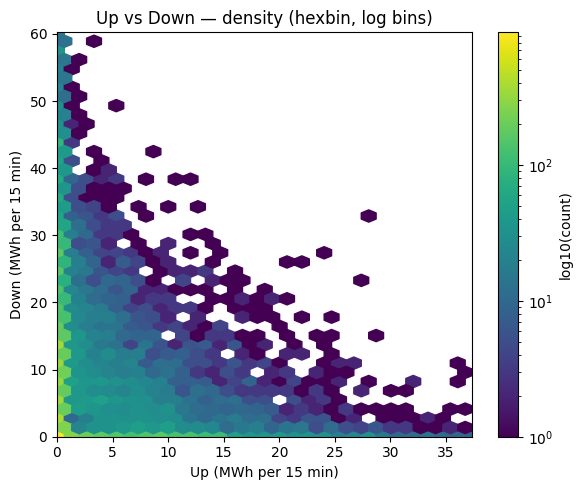

In [16]:
# Joint distribution of Up vs Down (per 15-min), using hexbin for density
sel = df[(df['aFRR Activated Up'] > 0) | (df['aFRR Activated Down'] > 0)]
if len(sel) == 0:
    print('No positive up/down pairs to visualize.')
else:
    u = sel['aFRR Activated Up'].values
    d = sel['aFRR Activated Down'].values
    max_u = np.quantile(u, 0.995)
    max_d = np.quantile(d, 0.995)
    fig, ax = plt.subplots(1, 1, figsize=(6,5))
    hb = ax.hexbin(u, d, gridsize=50, bins='log', cmap='viridis')
    ax.set_xlim(0, max_u)
    ax.set_ylim(0, max_d)
    ax.set_xlabel('Up (MWh per 15 min)')
    ax.set_ylabel('Down (MWh per 15 min)')
    ax.set_title('Up vs Down — density (hexbin, log bins)')
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('log10(count)')
    plt.tight_layout()
    plt.show()

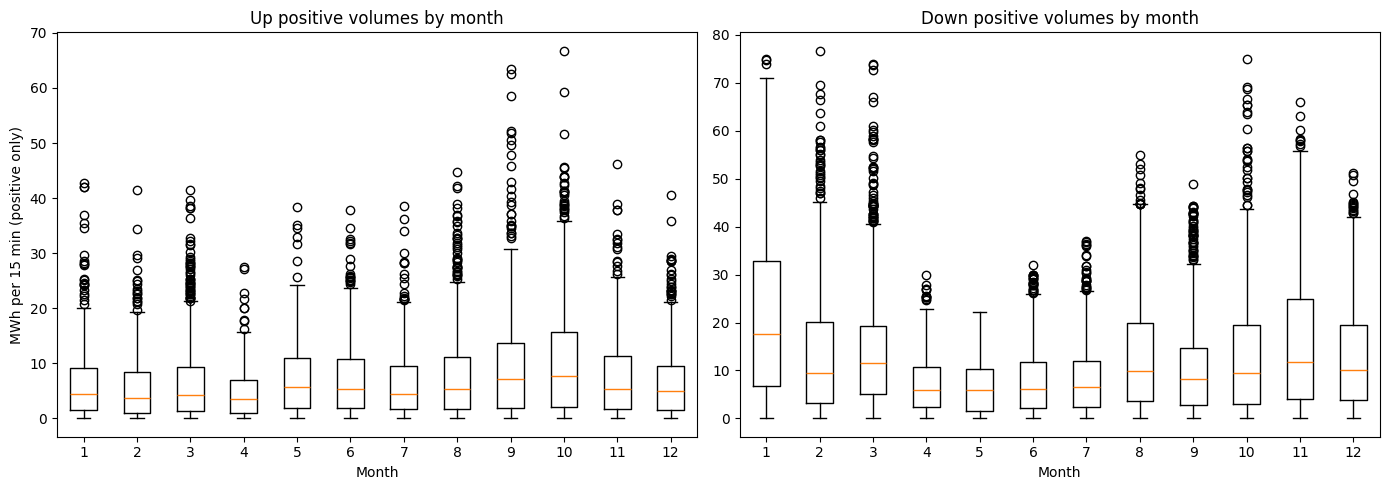

In [17]:
# Monthly seasonality: boxplots of positive volumes
tmp = df.copy()
tmp['month'] = tmp.index.month
up_pos = tmp.loc[tmp['aFRR Activated Up'] > 0, ['month','aFRR Activated Up']]
down_pos = tmp.loc[tmp['aFRR Activated Down'] > 0, ['month','aFRR Activated Down']]
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=False)
axes[0].boxplot([up_pos.loc[up_pos['month']==m, 'aFRR Activated Up'] for m in range(1,13)], positions=range(1,13))
axes[0].set_title('Up positive volumes by month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('MWh per 15 min (positive only)')
axes[0].set_xticks(range(1,13))

axes[1].boxplot([down_pos.loc[down_pos['month']==m, 'aFRR Activated Down'] for m in range(1,13)], positions=range(1,13))
axes[1].set_title('Down positive volumes by month')
axes[1].set_xlabel('Month')
axes[1].set_xticks(range(1,13))
plt.tight_layout()
plt.show()

In [ ]:
# Threshold exceedance rates and contribution tables
thresholds = [0.1, 1, 5, 10, 25, 50, 100]  # MWh per 15 min

def exceed_table(s):
    out = []
    tot = len(s)
    pos = (s > 0).sum()
    for t in thresholds:
        cnt = (s >= t).sum()
        out.append({'threshold_MWh': t, 'share_all': float(cnt/tot), 'share_of_positive': float(cnt/max(pos,1))})
    return pd.DataFrame(out)

ex_up = exceed_table(up)
ex_down = exceed_table(down)
print('Up exceedances:')
display(ex_up)
print('Down exceedances:')
display(ex_down)

Up exceedances:


,threshold_MWh,share_all,share_of_positive
0,0.1,0.375285,0.949661
1,1.0,0.319938,0.809606
2,5.0,0.196591,0.497476
3,10.0,0.105107,0.265974
4,25.0,0.015447,0.039088
5,50.0,0.000513,0.001298
6,100.0,0.000000,0.000000


Down exceedances:


,threshold_MWh,share_all,share_of_positive
0,0.1,0.542978,0.958736
1,1.0,0.493046,0.870572
2,5.0,0.382809,0.675926
3,10.0,0.274054,0.483897
4,25.0,0.095018,0.167774
5,50.0,0.012027,0.021236
6,100.0,0.000000,0.000000


: 